# Epidemics on networks

On this lab we will consider an implementation of disease spreading over a network. We will start from SIS model and slightly modify it to SIR model.

## SIS model

Just to recall from the lecture how it looks like:
\begin{equation}
   \begin{cases}
   \cfrac{ds_i(t)}{dt} = -\beta s_i(t)\sum\limits_j A_{ij}x_j(t) + \gamma x_i(t)\\
   \cfrac{dx_i(t)}{dt} = \beta s_i(t)\sum\limits_j A_{ij}x_j(t) - \gamma x_i(t)
  \end{cases}
  \\
  x_i(t) + s_i(t) = 1
\end{equation}
where $x_i(t)$ and $s_i(t)$ are probabilities for a node $v_i$ to be infected or susceptable.

In [1]:
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
from numpy.linalg import eig
from scipy.integrate import odeint
import networkx as nx
%matplotlib inline

In [7]:
# Let's start from a complete graph
n = 500
G = nx.watts_strogatz_graph(n, 5, 0.4)

# Get adj. matrix
A = np.array(nx.adjacency_matrix(G).todense())

# Spreading\restoring coefficient
beta, gamma = 0.25, 0.5

# Time domain
t = np.arange(0,50,0.05)

# Initial state
idx = np.random.choice(range(n), 5)
i0 = np.zeros((n,))
i0[idx] = 1
# i0 = np.random.random_integers(0,1,[n,])
z0 = np.concatenate((1-i0,i0))

# System of differential equations..
def sis(z, t, A, n, beta, gamma):
    return np.concatenate((
        -beta * z[0:n] * A.dot(z[n:2*n]) + gamma * z[n:2*n],
         beta * z[0:n] * A.dot(z[n:2*n]) - gamma * z[n:2*n]))
        

z = odeint(sis, z0, t, (A, n, beta, gamma))

Text(0.5, 1.0, 'Probability for all nodes')

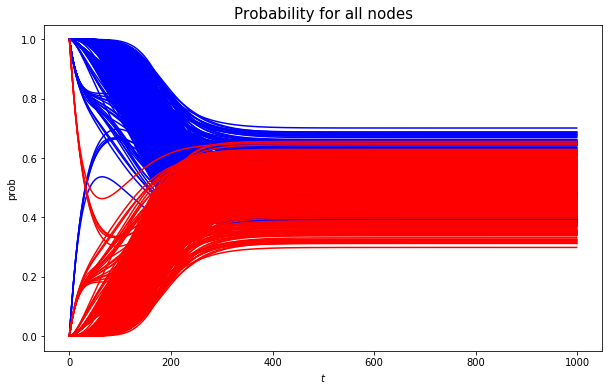

In [8]:
# Plot probs for some node
nId = 6
s = z[:,0:n]
x = z[:,n:2*n]


fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(s,color = 'blue')
ax.plot(x,color = 'red')
ax.set_xlabel('$t$')
ax.set_ylabel('prob')
ax.set_title('Probability for all nodes', fontsize = 15)

Hope that you remember that stuff about the correspondence between largest eigenvalue and $\frac{\gamma}{\beta}$ ratio:<br/>
* if $\lambda_1 > \frac{\gamma}{\beta}$ - GROWTH
* if $\lambda_1 < \frac{\gamma}{\beta}$ - NOPE <br/>
Check it

In [6]:
w,v = eig(A)
print(max(w), gamma/beta)

4.3118741458171375 6.666666666666667


### Task

1. Play with $\gamma$, $\beta$ parameters and try out SIS model for other graphs
2. Does it matter how many nodes are initially infected?

## SIR model

In SIR model healed population gain immunity to the infection
\begin{equation}
   \begin{cases}
   \cfrac{ds_i(t)}{dt} = -\beta s_i(t)\sum\limits_j A_{ij} x_j(t)\\
   \cfrac{dx_i(t)}{dt} = \beta s_i(t)\sum\limits_j A_{ij} x_j(t) - \gamma x_i(t)\\
   \cfrac{dr_i(t)}{dt} = \gamma x_i(t)
  \end{cases}
  \\
  x_i(t) + s_i(t) + r_i(t) = 1
\end{equation}

 SIR model

In [13]:
# Let's start from a complete graph
n = 50
G = nx.barabasi_albert_graph(n, 5)

# Get adj. matrix
A = np.array(nx.adjacency_matrix(G).todense())


# Spreading\restoring coefficient
beta, gamma = 0.17, 0.2

# Time domain
t = np.arange(0,30,0.05)

# Initial state
idx = np.random.choice(range(n), 30)
i0 = np.zeros((n,))
i0[idx] = 1
# i0 = np.random.random_integers(0,1,[n,])
z0 = np.concatenate((1-i0,i0,np.zeros((n,))))

# System of differential equations..
def sir(z, t, A, n, beta, gamma):
    return np.concatenate((
        -beta * z[0:n] * A.dot(z[n:2*n]),
         beta * z[0:n] * A.dot(z[n:2*n]) - gamma * z[n:2*n],
         gamma * z[n:2*n]
        ))
        
z = odeint(sir, z0, t, (A, n, beta, gamma))

Text(0.5, 1.0, 'Probability for all nodes')

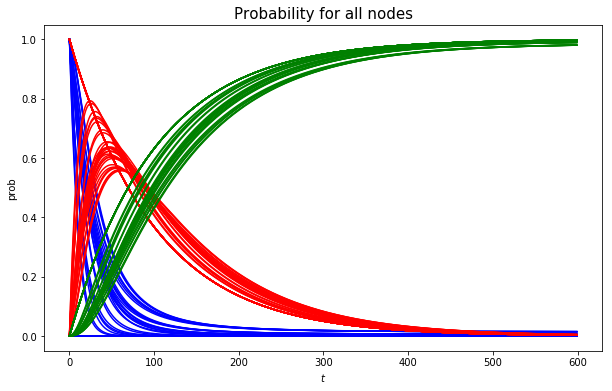

In [14]:
# Plot probs for some node
nId = 6
s = z[:,0:n]
x = z[:,n:2*n]
r = z[:,2*n:3*n]


fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(s,color = 'blue')
ax.plot(x,color = 'red')
ax.plot(r,color = 'green')
ax.set_xlabel('$t$')
ax.set_ylabel('prob')
ax.set_title('Probability for all nodes', fontsize = 15)



Text(0.5, 1.0, 'Probability for all nodes')

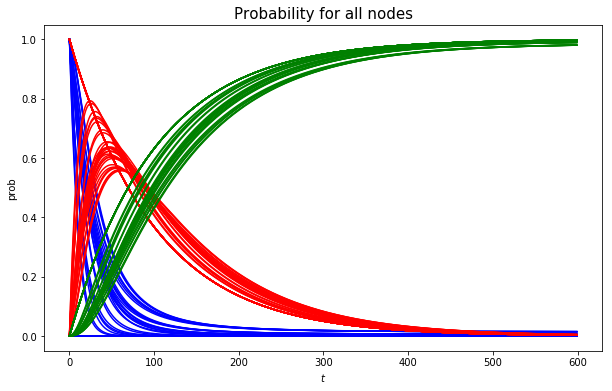

In [15]:
# Plot probs for some node
nId = 6
s = z[:,0:n]
x = z[:,n:2*n]
r = z[:,2*n:3*n]


fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(s,color = 'blue')
ax.plot(x,color = 'red')
ax.plot(r,color = 'green')
ax.set_xlabel('$t$')
ax.set_ylabel('prob')
ax.set_title('Probability for all nodes', fontsize = 15)


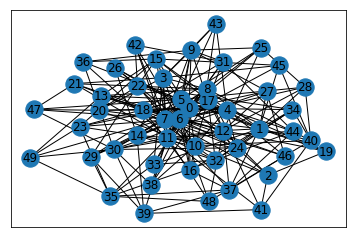

In [16]:
nx.draw_networkx(G)

## Stochastic Modelling

The stuff that you will see below is kind of simulation model of infection spreading on graph. The description of the model is the following: <br/>

* The infection has some vital period, the node is diseased for that period
* At the end of this period node become susceptible without immunity system's reinforcement
* Each infected node can spread disease within its neigbours with a sertain probability

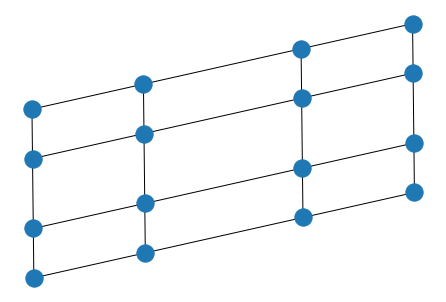

In [17]:
size = 4
# Create Grid Graph
G = nx.grid_2d_graph(size,size)

# Make node relabelling
f = {}
for v in G.nodes:
    f[v] = v[0]*size+v[1]

G = nx.relabel_nodes(G, f)
nx.draw_spectral(G)

In [22]:
def simulSIS(A, timePeriod, modelParams):
    # init params
    initInfected = modelParams.get('initInfected', None)
    p = modelParams.get('probInfect', 0.5)
    upd = modelParams.get('updateInfection', True)
    maxRecTime = modelParams.get('t2Recover', 2)
    
    # init output
    n = A.shape[0]
    states = np.zeros([n, timePeriod+1]) # 1 = infected, 0 = susceptable
    recTime = np.zeros(n,)
    # set initially infected nodes
    if initInfected is None:
        initInfected = np.random.choice(range(n), n//2)
        states[initInfected,0] = 1
    else:
        states[initInfected,0] = 1
    recTime[initInfected] = maxRecTime + 1
    
    # Start simulation
    for t in range(1, timePeriod+1):
        recTime = np.maximum(recTime-1,0)
        states[recTime>0, t] = 1
        states[recTime==0, t] = 0
        
        curInf = np.nonzero(states[:,t])[0]
        states[curInf, t] = 1
        for i in curInf:
            #NN = np.setdiff1d(np.nonzero(A[i,])[0], curInf)
            NN = np.nonzero(A[i,])[0]
            infNN = NN[np.random.rand(len(NN))<p]
            states[infNN, t] = 1
            recTime[infNN] = maxRecTime + 1
            
    return states
    

In [23]:
# Running model

timePeriod = 11
modelParams = {}
modelParams['t2Recover'] = 3
modelParams['initInfected'] = None
modelParams['probInfect'] = 0.1
modelParams['updateInfection'] = True

A = np.array(nx.adjacency_matrix(G).todense())

states = simulSIS(A, timePeriod, modelParams)

In [24]:
states

array([[1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0.]])

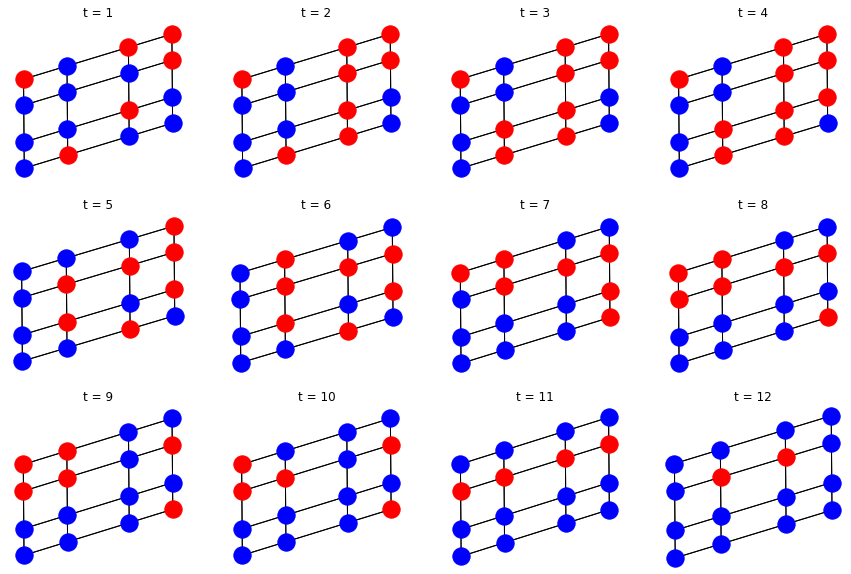

In [25]:
# Plotting inferction spread

pos = nx.spectral_layout(G)
fig = plt.figure(figsize=(15,10))
for t in range(0,timePeriod+1):
    plt.subplot(3,4,t+1)
    nx.draw_spectral(G,
        nodelist=np.nonzero(states[:,t])[0].tolist(),
        node_color = 'r')
    nx.draw_spectral(G,
        nodelist=np.nonzero(1-states[:,t])[0].tolist(),
        node_color = 'b')
    plt.title('t = {0}'.format(t+1))